In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

StateSpaceDynamics

# Gaussian HMM

In [2]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

println("here")
# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

println("Sampling")
# Sample from the model
n=20000
true_labels, data = SSD.sample(true_model, n=n)


println("fitting")
# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(test_model, data)

print(isapprox(test_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, true_model.B[2].μ, atol=0.1))
print(isapprox(test_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, true_model.B[1].μ, atol=0.1))

here
Sampling
fitting


Running EM algorithm...   2%|█                           |  ETA: 0:01:34

Running EM algorithm...  14%|████                        |  ETA: 0:00:23

Running EM algorithm...  25%|████████                    |  ETA: 0:00:15

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:05


truetrue

# Switching Gaussian Regression #

In [3]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(n, 3)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
ll = SSD.fit!(test_model, data, Φ)

# Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))

Running EM algorithm...   2%|█                           |  ETA: 0:02:17

Running EM algorithm...  11%|████                        |  ETA: 0:00:33

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:05


truetrue

In [4]:
ll

21-element Vector{Float64}:
     -Inf
 -341660.6289969877
 -122982.81953274357
 -122982.81946320728
 -122982.79511687695
 -122970.25333632666
 -118176.01379563853
  -54672.43911972539
  -37362.94420352121
  -36265.59364853455
       ⋮
  -36034.35754929385
  -36033.548407759255
  -36033.42306233435
  -36033.405871637624
  -36033.40357198191
  -36033.403265150584
  -36033.40322415516
  -36033.403218682186
  -36033.40321794437

# Switching Bernoulli Regression #

In [5]:
"""
Create Bernoulli Regression Model
"""
# Make Emission Models
emission_1 = SSD.BernoulliRegressionEmission(input_dim=2, include_intercept=true, β = [3, 1, 8])
emission_2 = SSD.BernoulliRegressionEmission(input_dim=2, include_intercept=true, β = [-4, -5, 0.1])

# Create Switching Bernoulli Regression and add the emissions
true_model = SSD.SwitchingBernoulliRegression(K=2, input_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n=20000
Φ = randn(n, 2)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Fit a new Bernoulli Regression Model to the data
test_model = SSD.SwitchingBernoulliRegression(K=2, input_dim=2)
ll = SSD.fit!(test_model, data, Φ, max_iters=200)

# # Test it works alright
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))

Running EM algorithm...   1%|█                           |  ETA: 0:02:38

Running EM algorithm...   5%|██                          |  ETA: 0:00:53

Running EM algorithm...  10%|███                         |  ETA: 0:00:37

Running EM algorithm...  14%|████                        |  ETA: 0:00:31

Running EM algorithm...  18%|█████                       |  ETA: 0:00:29

Running EM algorithm...  22%|███████                     |  ETA: 0:00:25

Running EM algorithm...  26%|████████                    |  ETA: 0:00:23

Running EM algorithm...  30%|█████████                   |  ETA: 0:00:22

Running EM algorithm...  34%|██████████                  |  ETA: 0:00:20

Running EM algorithm...  39%|███████████                 |  ETA: 0:00:18

Running EM algorithm...  44%|█████████████               |  ETA: 0:00:17

Running EM algorithm...  48%|██████████████              |  ETA: 0:00:15

Running EM algorithm...  52%|███████████████             |  ETA: 0:00:13

Running EM algorithm...  57%|█████████

falsetrue

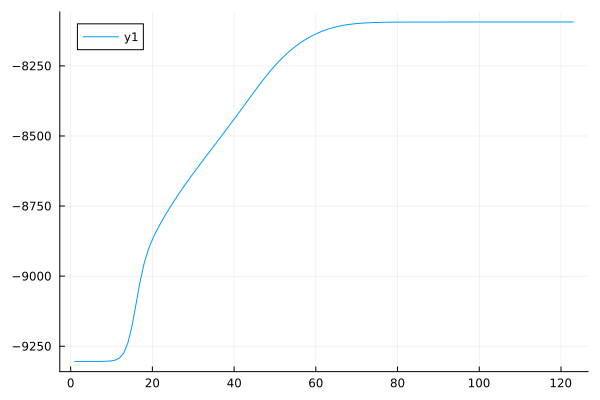

In [6]:
plot(ll[3:end])

# Switching Poisson Regression

In [12]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, include_intercept=true, β=[4, 3, 2, 4])
emission_2 = PoissonRegressionEmission(input_dim=3, include_intercept=true, β=[-4, -2, 1, 3])

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(n, 3)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, include_intercept=true, β=[2.0, 1.0, 4.0, 2.0])
emission_2 = PoissonRegressionEmission(input_dim=3, include_intercept=true, β=[-5.0, -1.0, 0.0, 2.0])
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=200)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))


Running EM algorithm...   2%|█                           |  ETA: 0:01:11

Running EM algorithm...   4%|██                          |  ETA: 0:00:47

Running EM algorithm...   7%|██                          |  ETA: 0:00:43

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:03


truetrue

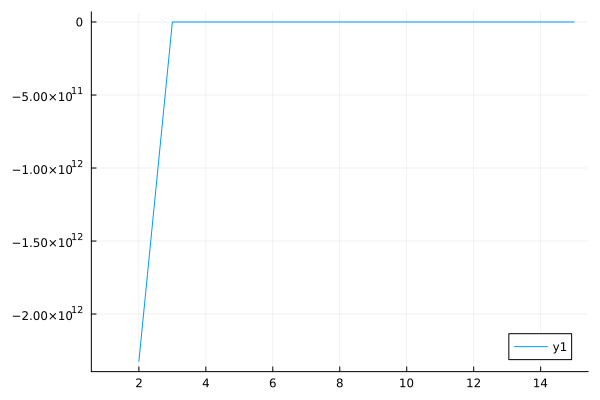

In [18]:
plot(ll)